In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import classification_report
import xgboost as xgb

In [2]:
root = "../../../../"

In [3]:
df = pd.read_csv(root + "datasets/multiclass/processed/CICDDoS_basic.csv", index_col=[0])

In [4]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1.0,2.0,0.0,2736.0,0.0,1368.0,1368.0,1368.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
1,1.0,2.0,0.0,2650.0,0.0,1325.0,1325.0,1325.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
2,2.0,2.0,0.0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
3,46.0,2.0,0.0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
4,1.0,2.0,0.0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS


In [5]:
X = df.drop(columns=[' Label'])
y = df[' Label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42, stratify=y)

___
# Remove correlated features (keeping one of them)

In [7]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat > 0.9]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():    
    if feature not in grouped_feature_ls:
        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]
        # append the block of features to the list
        correlated_groups.append(correlated_block)

group_head = []

for group in correlated_groups:
    group_head.append(group.iloc[0,0])

features_to_remove = [feature for feature in grouped_feature_ls if feature not in group_head]

X_train.drop(columns=features_to_remove, inplace=True)
X_test.drop(columns=features_to_remove, inplace=True)

C:\Users\pedro\miniconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


___
# Training a model

In [8]:
clf_xgb = xgb.XGBClassifier(seed=42)
# clf_xgb.fit(X_train, 
#             y_train,
#             verbose=True,
#             ## the next three arguments set up early stopping.
#             early_stopping_rounds=5,
#             eval_metric='mlogloss',
#             eval_set=[(X_test, y_test)])
clf_xgb.fit(X_train, y_train)

C:\Users\pedro\miniconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[23:05:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

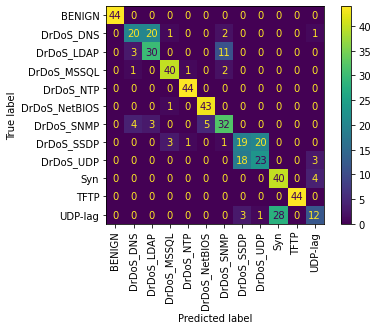

In [9]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      xticks_rotation='vertical')
plt.savefig(root + 'pictures/multiclass_categorical/cm_corr.png', bbox_inches='tight')

In [10]:
y_pred = clf_xgb.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred, digits=4))

               precision    recall  f1-score   support

       BENIGN     1.0000    1.0000    1.0000        44
    DrDoS_DNS     0.7143    0.4545    0.5556        44
   DrDoS_LDAP     0.5660    0.6818    0.6186        44
  DrDoS_MSSQL     0.8889    0.9091    0.8989        44
    DrDoS_NTP     0.9565    1.0000    0.9778        44
DrDoS_NetBIOS     0.8958    0.9773    0.9348        44
   DrDoS_SNMP     0.6667    0.7273    0.6957        44
   DrDoS_SSDP     0.4750    0.4318    0.4524        44
    DrDoS_UDP     0.5227    0.5227    0.5227        44
          Syn     0.5882    0.9091    0.7143        44
         TFTP     1.0000    1.0000    1.0000        44
      UDP-lag     0.6000    0.2727    0.3750        44

     accuracy                         0.7405       528
    macro avg     0.7395    0.7405    0.7288       528
 weighted avg     0.7395    0.7405    0.7288       528

